# Dimensionality reduction
[Contributions](#contributions)

fMRI analysis often has a dimensionality problem: we get approximately 100,000 voxels (i.e., features) per volume, but only 100s of time points or trials (i.e., examples). This makes it very hard for machine learning algorithms to model how each voxel contributes. For more general information on this problem, also dubbed the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality), see [these slides from the Texas A&M University Computer Science and Engineering Department](http://courses.cs.tamu.edu/choe/11spring/633/lectures/slide08.pdf). For a neuroimaging-specific view on the curse of dimensionality, you might want to take a look at [Mwangi et al.'s Neuroinformatics review from 2014](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4040248/).

In this notebook we are going to learn various methods that can help us reduce the dimensionality of fMRI data.

## Goal of this script
1. Learn to compute the covariance of a dataset.  
2. Reduce the feature space using principal component analysis (PCA).  
3. Interpret the meaning of PCA components.  
4. Perform feature selection using cross-validation.  

## Pre-requisites
You should be familiar with the functions in the data loading and classification notebooks.

## Table of Contents
[1. Load the data](#load-data)  

[2. Covariance](#covariance)  

[3. PCA](#pca)  
>[3.1 Plot PCA](#plot_pca)  
>[3.2 Scree Plots](#scree)  
>[3.3 Interpreting Components](#cog-relevance)  
>[3.4 Normalization](#pca-norm)  
>[3.5  PCA dimensionality reduction and classification](#wb-pca-class)  

[4. Feature Selection](#feat)  
>[4.1 Feature Selection: Pipelines](#pipeline)  
>[4.2 Feature Selection: Univariate](#univariate)   

Exercises
>[Exercise 1](#ex1)  [2](#ex2)  [3](#ex3)  [4](#ex4)  [5](#ex5)  [6](#ex6)  [7](#ex7)  [8](#ex8)   [9](#ex9)


**Dataset:** For this script we will use a localizer dataset from [Kim et al. (2017)](https://doi.org/10.1523/JNEUROSCI.3272-16.2017) again. Just to recap: The localizer consisted of 3 runs with 5 blocks of each category (faces, scenes and objects) per run. Each block was presented for 15s. Within a block, a stimulus was presented every 1.5s (1 TR). Between blocks, there was 15s (10 TRs) of fixation. Each run was 310 TRs. In the matlab stimulus file, the first row codes for the stimulus category for each trial (1 = Faces, 2 = Scenes, 3 = Objects). The 3rd row contains the time (in seconds, relative to the start of the run) when the stimulus was presented for each trial.



In [1]:
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter('ignore')

# Import neuroimaging, analysis and general libraries
import numpy as np
from time import time
import pandas as pd

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import cross_val_score, cross_validate, PredefinedSplit
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, RFECV, f_classif
from sklearn.pipeline import Pipeline

%matplotlib inline
%autosave 5
sns.set(style = 'white', context='poster', rc={'lines.linewidth': 2.5})
sns.set(palette="colorblind")

Autosaving every 5 seconds


In [2]:
# load some helper functions
from utils import load_labels, load_data, blockwise_sampling, label2TR, shift_timing, reshape_data
from utils import normalize, decode
# load some constants
from utils import vdc_data_dir, vdc_all_ROIs, vdc_label_dict, vdc_n_runs, vdc_hrf_lag, vdc_TR, vdc_TRs_run

print('Here\'re some constants, which is specific for VDC data:')
print('data dir = %s' % (vdc_data_dir))
print('ROIs = %s' % (vdc_all_ROIs))
print('Labels = %s' % (vdc_label_dict))
print('number of runs = %s' % (vdc_n_runs))
print('1 TR = %.2f sec' % (vdc_TR))
print('HRF lag = %.2f sec' % (vdc_hrf_lag))
print('num TRs per run = %d' % (vdc_TRs_run))

Here're some constants, which is specific for VDC data:
data dir = /Users/brandon/Desktop/fMRI/brainiak/brainiak_datasets/vdc
ROIs = ['FFA', 'PPA']
Labels = {1: 'Faces', 2: 'Scenes', 3: 'Objects'}
number of runs = 3
1 TR = 1.50 sec
HRF lag = 4.50 sec
num TRs per run = 310


## 1. Load the data <a id="load-data"></a>

Load the data for one participant using these helper functions.

In [3]:
sub_id = 1
mask_name = 'FFA' # This is set in order to reduce memory demands in order to run within 4Gb, however, if you want to make this run on whole brain, then set this to ''

In [4]:
# Specify the subject name
sub = 'sub-%.2d' % (sub_id)
# Convert the shift into TRs
shift_size = int(vdc_hrf_lag / vdc_TR)  

# Load subject labels
stim_label_allruns = load_labels(vdc_data_dir, sub)

# Load run_ids
run_ids_raw = stim_label_allruns[5,:] - 1 

# Load the fMRI data using a mask
epi_mask_data_all = load_data(vdc_data_dir, sub, mask_name=mask_name)[0]

# This can differ per participant
print(sub, '= TRs: ', epi_mask_data_all.shape[1], '; Voxels: ', epi_mask_data_all.shape[0])
TRs_run = int(epi_mask_data_all.shape[1] / vdc_n_runs)

# Convert the timing into TR indexes
stim_label_TR = label2TR(stim_label_allruns, vdc_n_runs, vdc_TR, TRs_run)

# Shift the data some amount
stim_label_TR_shifted = shift_timing(stim_label_TR, shift_size)

# Perform the reshaping of the data
bold_data_raw, labels_raw = reshape_data(stim_label_TR_shifted, epi_mask_data_all)

# Normalize raw data within each run
bold_normalized_raw = normalize(bold_data_raw, run_ids_raw)

# Down sample the data to be blockwise rather than trialwise. 
#We'll use the blockwise data for all the 
bold_data, labels, run_ids = blockwise_sampling(bold_data_raw, labels_raw, run_ids_raw)

# Normalize blockwise data within each run
bold_normalized = normalize(bold_data, run_ids)

Loaded  sub-01
Processing Start ...
Loaded FFA mask
Loading data from /Users/brandon/Desktop/fMRI/brainiak/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /Users/brandon/Desktop/fMRI/brainiak/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /Users/brandon/Desktop/fMRI/brainiak/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
sub-01 = TRs:  930 ; Voxels:  5519
Expected blocks: 45; Resampled blocks: 45


<div class="alert alert-block alert-info">
<strong>Block Averaging</strong>
<br>
Previously, we have been using data from each trial. Within each block, the voxel activity is correlated across trials. Thus, it is common (and probably better) to take the average value of the activity within a block as your observation in decoding analyses in order to avoid concerns about non-independence. Mean values of activity or beta coefficients (from GLM) are commonly used in the literature.
</div>

**Self-study:** We introduce a simple kind of debugging here, as we print both the number of expected and resampled blocks (resampled refers to the conversion from trialwise data to blockwise data). Thus, if something went wrong, we would be able to spot it the output. Learn about more ways of debugging your code by using assertions [here](https://wiki.python.org/moin/UsingAssertionsEffectively).

## 2. Covariance <a id="covariance"></a>

As a precursor to understanding dimensionality reduction techniques, we need to learn how to compute the covariance matrix because it is often used in these methods.  

By default, we used an FFA mask to reduce the memory demands in this notebook, but if possible we recommend that you use no mask in order to grapple with the memory issues of working with wholebrain data. There are nearly 1 million voxels in every volume we acquire, of which about 15% are in the brain. The data matrix of >100,000 voxels and <1000 time points is very large, making any computations on all of this data very intensive.

The covariance of two variables is calculated as follows: $$ Cov(X,Y) = \frac{\sum_{1}^{N}(X-\bar{X})(Y-\bar{Y})}{(N-1)}$$
where $\mbox{  }  \bar{X} = mean(X), \mbox{  } \bar{Y} = mean(Y), \mbox{  } N = \mbox{number of samples } $

In fMRI, X and Y could be time-series data for two voxels (two columns in our time by voxels data matrix) or the pattern across voxels for two different time points (two rows in the data matrix). The choice of vectors depends on the application.

**Exercise 1:** <a id="ex1"></a> Compute the covariance between two blocks (i.e., their averaged patterns across voxels). The steps to do this are outlined below. You could just use a function but we want you to code the individual steps as described (refer [here]( https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.cov.html) for additional help)


In [5]:
# Enter your code here

# Compute the mean of one row of the block-averaged bold data called: X
X = bold_normalized[10, :]
X_mean = np.mean(X)

# Compute the mean of any other row of the block-averaged bold data called: Y
Y = bold_normalized[20, :]
Y_mean = np.mean(Y)

# Compute the differences of individual voxel values in these rows from the corresponding mean for X or Y.
X_diffs = X - X_mean
Y_diffs = Y - Y_mean

# Compute the pointwise product of the difference vectors across the two rows.
diff_prod = np.multiply(X_diffs, Y_diffs)

# Sum over the products of the differences.
diff_sum = np.sum(diff_prod)

# Complete the covariance calculation with these values.
cov_manual = diff_sum/(X.shape[0] - 1)

# Compare your result to the answer obtained with np.cov(X,Y)
cov_auto = np.cov(X, Y)[1][0]

print('Manual covariance: {}; automatic covariance: {}'.format(cov_manual, cov_auto))

Manual covariance: -0.03511234506686155; automatic covariance: -0.03511234506686155


Covariance is dependent on the unit and scale of the measurement. Its value is thus not easily interpretable or comparable across datasets -- e.g. is there a strong relationship between X and Y if the covariance is 200 as compared to 2 or 2000?

Correlation solves this problem by normalizing the range of the covariance from -1 to +1.

$$ Corr(X,Y) = \frac{Cov(X,Y)}{\sqrt{\frac{\sum_{1}^{N}(X-\bar{X})^2}{(N-1)}}\sqrt{\frac{\sum_{1}^{N}(Y-\bar{Y})^2}{(N-1)}}}$$

**Exercise 2:** <a id="ex2"></a> Compute the correlation between all pairs of blocks manually (one pair at a time) and compare the result with a numpy function that calculates the block-by-block correlation matrix in one step.

In [6]:
# Compute the correlation manually
corr_manual = cov_manual/(np.sqrt((np.sum(((X_diffs)**2)))/(X.shape[0] - 1)) *
                          np.sqrt((np.sum(((Y_diffs)**2)))/(Y.shape[0] - 1)))

# Now with a function
corr_auto = np.corrcoef(X, Y)[0][1]

print('Manual correlation: {}; automatic correlation: {}'.format(corr_manual, corr_auto))

Manual correlation: -0.04726873436910835; automatic correlation: -0.04726873436910835


**Exercise 3**: <a id="ex3"></a> Now compute the covariance between time-series across pairs of voxels (using the np.cov). Perform this compution on a group of 100 voxels in order to make a voxel-by-voxel covariance matrix in one step (no `for` loops allowed). Make sure the output is the correct shape (100, 100).  

In [7]:
# Insert your code here.

# Subselect 100 voxels from bold_data into a matrix.
bold_subset = np.matrix(bold_data[:, 0:100]).T
print(bold_subset.shape)
# Use np.cov() to compute the covariance of this matrix.
cov_auto_subset = np.cov(bold_subset)
print(cov_auto_subset.shape)

(100, 45)
(100, 100)


## 3. PCA <a id="pca"></a>

We will use principal component analysis (PCA) to **reduce the dimensionality** of the data. Some voxels may contain correlated information or no information and so the original voxel-dimensional data matrix (time-by-voxels) can be projected into a lower-dimensional "component" matrix space (time-by-component) without losing much information.

![image](https://cdn-images-1.medium.com/max/1200/1*Iri_LDMXuz2Qac-8KPeESA.png)

In [8]:
# We now use the PCA function in scikit-learn to reduce the dimensionality of the data
# The number of components was chosen arbitrarily.
pca = PCA(n_components=20)
bold_pca = pca.fit_transform(bold_data)

print('Original data shape:', bold_data.shape)
print('PCA data shape:', bold_pca.shape)

Original data shape: (45, 5519)
PCA data shape: (45, 20)


### 3.1 Plot PCA <a id="plot_pca"></a>

Let's visualize the variance in the data along different component dimensions.

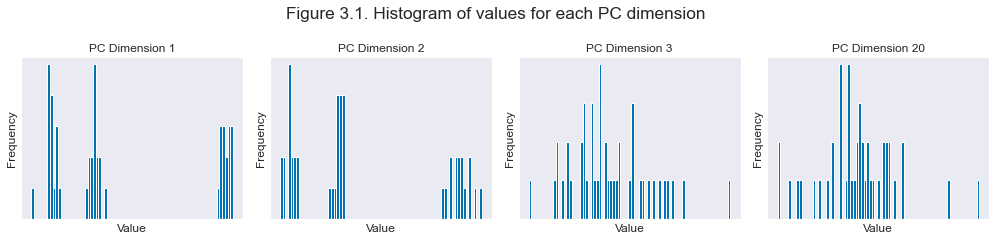

In [9]:
# Setting plotting parameter
n_bins=75

# Plot
n_plots = 4
components_to_plot = [0,1,2,19]
f, axes = plt.subplots(1, n_plots, figsize=(14, 14/n_plots))
st=f.suptitle("Figure 3.1. Histogram of values for each PC dimension ", fontsize="x-large")

for i in range(n_plots): 
    axes[i].hist(bold_pca[:, components_to_plot[i]], 
                 bins=n_bins)
    # mark the plots 
    axes[i].set_title('PC Dimension %d'%(components_to_plot[i]+1))
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlabel('Value')    
    axes[i].set_xticks([])
    axes[i].set_yticks([])    

f.tight_layout()
st.set_y(0.95)
f.subplots_adjust(top=0.75)


Let's visualize the relationship between variances across pairs of components.

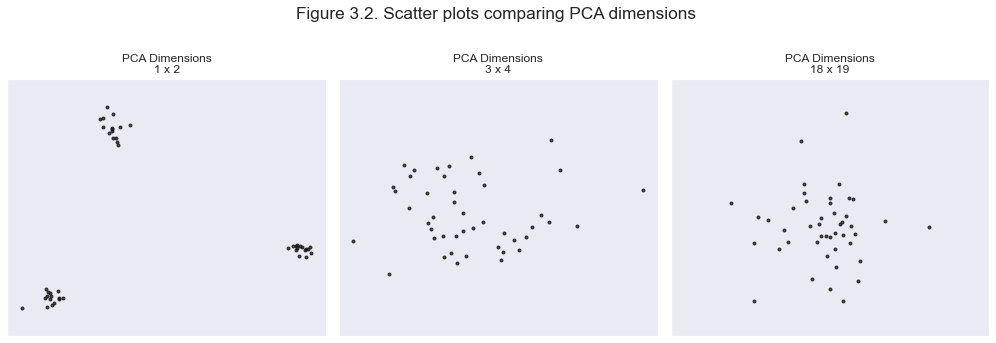

In [10]:
"""
Plot the low dim representation of the bold data
"""
# Setting plotting parameters
alpha_val = .8
cur_pals = sns.color_palette('colorblind', n_colors=vdc_n_runs)

# Plot
n_plots = 3 
f, axes = plt.subplots(1, n_plots, figsize=(14,5))
st=f.suptitle("Figure 3.2. Scatter plots comparing PCA dimensions ", fontsize="x-large")

# plot data
axes[0].scatter(bold_pca[:, 0], bold_pca[:, 1], 
                alpha=alpha_val, marker='.', color = 'k')
axes[1].scatter(bold_pca[:, 2], bold_pca[:, 3], 
                alpha=alpha_val, marker='.', color = 'k')
axes[2].scatter(bold_pca[:, 18], bold_pca[:, 19], 
                alpha=alpha_val, marker='.', color = 'k')

axes[0].set_title('PCA Dimensions\n1 x 2')
axes[1].set_title('PCA Dimensions\n3 x 4')
axes[2].set_title('PCA Dimensions\n18 x 19')

# modifications that are common to all plots 
for i in range(n_plots): 
    axes[i].axis('equal')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

f.tight_layout()
st.set_y(0.95)
f.subplots_adjust(top=0.75)


### 3.2 Scree plots <a id="scree"></a>

A ["scree" plot](https://www.theanalysisfactor.com/factor-analysis-how-many-factors/) can depict the amount of variance in the original data that is explained by each component.

**Exercise 4:** <a id="ex4"></a> Make a scree plot for the PCA above. How many components would be sufficient to account for most of the variance?

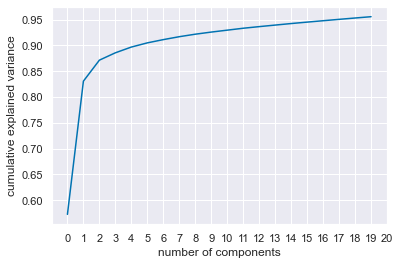

In [11]:
# Get explained variance ratio
explained_variance_ratio = pca.fit(bold_data).explained_variance_ratio_

# Plot the scree plot
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xticks(np.arange(0, 21, 1))
plt.show()

**A:**
After two components, the cumulative explained variance goes to > 85%.

### 3.3 Interpreting Components  <a id="cog-relevance"></a>

From the previous plot of the first and second PCA dimension, you can see you have three clusters. You might assume that they correspond to faces, scenes, and objects.

**Exercise 5:**  <a id="ex5"></a>Determine what the three clusters correspond to. First, create a new scatter plot of these two components and mark (e.g., in different symbols or colors) each point on the plot by visual category. Then, create a second scatter plot with points labeled in a way that better corresponds to the clusters (complete this exercise before reading further). (Hint: What else was there three of?)

In [12]:
print(labels)

[2. 2. 2. 3. 1. 1. 3. 1. 3. 1. 3. 2. 1. 3. 2. 2. 2. 3. 1. 3. 1. 3. 1. 3.
 2. 3. 2. 1. 1. 2. 1. 2. 3. 3. 2. 3. 1. 2. 1. 3. 1. 2. 3. 1. 2.]


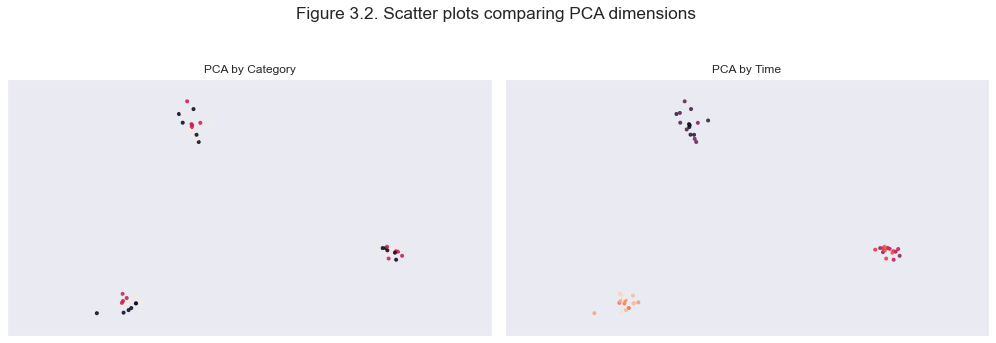

In [15]:
# Put answer

# Setting plotting parameters
alpha_val = .8
cur_pals = sns.color_palette('colorblind', n_colors=vdc_n_runs)

# Plot
n_plots = 2
f, axes = plt.subplots(1, n_plots, figsize=(14,5))
st=f.suptitle("Figure 3.2. Scatter plots comparing PCA dimensions ", fontsize="x-large")

# plot data
axes[0].scatter(bold_pca[:, 0], bold_pca[:, 1],
                alpha=alpha_val, marker='.', c = labels)
axes[1].scatter(bold_pca[:, 0], bold_pca[:, 1],
                alpha=alpha_val, marker='.', c = range(0, 45))

axes[0].set_title('PCA by Category')
axes[1].set_title('PCA by Time')

# modifications that are common to all plots
for i in range(n_plots):
    axes[i].axis('equal')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

f.tight_layout()
st.set_y(0.95)
f.subplots_adjust(top=0.75)

### 3.4 Normalization <a id="pca-norm"></a>

We ran the PCA analysis without normalizing the data.

**Exercise 6:**<a id="ex6"></a> Using the variable `bold_normalized` re-compute the PCA (components=20). Plot the results with a scatter plot like **Figure 3.2**. What was the effect of normalization and why is this useful?

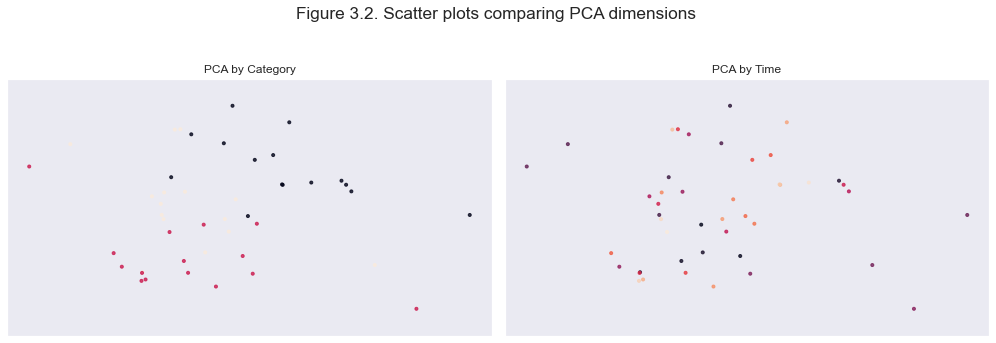

In [17]:
# Insert code here

# Put answer
bold_pca_norm = pca.fit_transform(bold_normalized)

# Setting plotting parameters
alpha_val = .8
cur_pals = sns.color_palette('colorblind', n_colors=vdc_n_runs)

# Plot
n_plots = 2
f, axes = plt.subplots(1, n_plots, figsize=(14,5))
st=f.suptitle("Figure 3.2. Scatter plots comparing PCA dimensions ", fontsize="x-large")

# plot data
axes[0].scatter(bold_pca_norm[:, 0], bold_pca_norm[:, 1],
                alpha=alpha_val, marker='.', c = labels)
axes[1].scatter(bold_pca_norm[:, 0], bold_pca_norm[:, 1],
                alpha=alpha_val, marker='.', c = range(0, 45))

axes[0].set_title('PCA by Category')
axes[1].set_title('PCA by Time')

# modifications that are common to all plots
for i in range(n_plots):
    axes[i].axis('equal')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

f.tight_layout()
st.set_y(0.95)
f.subplots_adjust(top=0.75)

# Get explained variance ratio
#explained_variance_ratio = pca.fit(bold_normalized).explained_variance_ratio_

# Plot the scree plot
# plt.plot(np.cumsum(explained_variance_ratio))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')
# plt.xticks(np.arange(0, 21, 1))
# plt.show()

### 3.5 PCA dimensionality reduction and classification <a id="wb-pca-class"></a>
As mentioned earlier, we use PCA to reduce the dimensionality of the data and thus minimize the 'curse of dimensionality'. Below we explore how PCA affects classification accuracy.

In [18]:
# Run a basic n-fold classification

# Get baseline, whole-brain decoding accuracy without PCA
print('Baseline classification')
print('Original size: ', bold_normalized.shape)
svc = SVC(kernel="linear", C=1)

start = time()
models, scores = decode(bold_normalized, labels, run_ids, svc)
end = time()
print('Accuracy: ', scores)
print('Run time: %0.4fs' %(end - start))

Baseline classification
Original size:  (45, 5519)
Accuracy:  [0.8666666666666667, 1.0, 1.0]
Run time: 0.0652s


In [19]:
# Run the classifier on data in component space 
pca = PCA(n_components=20)
bold_pca_normalized = pca.fit_transform(bold_normalized)
print('PCA (c=%d) classification' % bold_pca_normalized.shape[1])
print('New size after PCA: ', bold_pca_normalized.shape)

start = time()
models_pca, scores_pca = decode(bold_pca_normalized, labels, run_ids, svc)
end = time()
print('Accuracy: ', scores_pca)
print('Run time: %0.4fs' %(end - start))

PCA (c=20) classification
New size after PCA:  (45, 20)
Accuracy:  [0.8, 1.0, 0.9333333333333333]
Run time: 0.0090s


In this case PCA does not improve decoding accuracy. However, note that similar performance was achieved with 20 vs. 177,314 features, that the analysis ran 500x faster, and that the resulting model is likely to generalize better to new data (e.g., from a different subject).

**Exercise 7:** <a id="ex7"></a> We used an arbitrary number of components. How does decoding accuracy change with more or less components?

In [22]:
# Insert code
components_to_try = [5, 10, 15, 20, 25]
for components_n in components_to_try:
    pca_to_try = PCA(n_components=components_n)
    pca_to_use = pca_to_try.fit_transform(bold_normalized)
    models_pca_to_use, scores_pca_to_use = decode(pca_to_use, labels, run_ids, svc)
    print('Components: {} Accuracy: {}'.format(components_n, scores_pca_to_use))

Components: 5 Accuracy: [0.8666666666666667, 0.9333333333333333, 0.8]
Components: 10 Accuracy: [1.0, 0.8666666666666667, 1.0]
Components: 15 Accuracy: [1.0, 1.0, 1.0]
Components: 20 Accuracy: [0.8, 1.0, 0.9333333333333333]
Components: 25 Accuracy: [0.8666666666666667, 1.0, 1.0]


### 3.5.1 The PCA Challenge <a id="pca-challenge"></a>

**Exercise 8:** <a id="ex7"></a>Given that some of the early PCA dimensions may not be cognitively relevant, determine the smallest number of PCA components from which you can get the highest decoding accuracy. 

A: 15 components gives 100% accuracy.

## 4. Feature selection using cross-validation <a id="feat"></a>

When we took a few PCA components instead of all voxels, we were performing feature selection. Feature selection is used to reduce noise and increase computational speed. However, a problem with the approach above is that feature selection is applied to all data (prior to division into training and test sets) and is thus a kind of double dipping.

A better way to select features is during cross-validation. In this case, feature selection is only performed on the training set, and the same features are used on the test data. This way the classifier never sees the test data during training.

<div class="alert alert-block alert-warning">
<strong>Aside:</strong>  While doing PCA on the whole dataset violates the principle of “never touch your test data during training”, researchers have sometimes used this approach, justifying it on the grounds that — while PCA is using the fMRI data from the test set — it is not peeking at the class labels from the test set, and thus it will not bias classification accuracy. Is this OK? It’s difficult to say *a priori*. It is always safer to completely avoid touching the test data during training, so you should do this if at all possible. If you aren’t sure what problems might emerge from a particular analysis method, a good check of your method is to test on random noise; when you do this, classification should not exceed chance (if it does, you have a problem…)
</div>

We will perform feature selection during cross-validation in this section. The `Pipelines` method in scikit-learn provides an easy interface to perform these steps and we will use it extensively.



### 4.1 Pipelines: Feature selection with cross-validation  <a id="pipeline"></a>

The scikit-learn has a method, [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline), that simplifies running a sequence of steps in an automated fashion. Below we create a pipeline with the following steps:
  
>Perform dimensionality reduction.  
>Run an SVM.

To do this systematically during cross-validation, we will embed `Pipeline` in the `cross_validate` method in scikit-learn.

The steps below are based on [this example in scikit-learn](https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#illustration-of-pipeline-and-gridsearchcv).

In [23]:
# Example: 
# Set up the pipeline
pipe = Pipeline([
    ('reduce_dim', PCA(n_components=20)),
    ('classify', SVC(kernel="linear", C=1)),
])

# Run the pipeline with cross-validation
ps = PredefinedSplit(run_ids) # Provides train/test indices to split data in train/test sets
clf_pipe = cross_validate(
    pipe,bold_normalized,labels,cv=ps,
    return_train_score=True
)

# Print results from this dimensionality reduction technique
print(clf_pipe)
print ("Average Testing Accuracy: %0.2f" % (np.mean(clf_pipe['test_score'])))

{'fit_time': array([0.05109692, 0.03618598, 0.02209401]), 'score_time': array([0.00307012, 0.00117993, 0.00102997]), 'test_score': array([0.86666667, 0.93333333, 0.93333333]), 'train_score': array([1., 1., 1.])}
Average Testing Accuracy: 0.91


Print out the data indices that were used for training and testing. Ensure that they are different for each fold. 

In [24]:
# Print train/test split
for cv_idx ,(train_index, test_index) in enumerate(ps.split(bold_normalized, labels)):
    print('CV iteration: %s' % cv_idx)
    print('Train_index: ')
    print(train_index)
    print('Test_index: ')
    print(test_index)

# Print results from this dimensionality reduction technique
print(clf_pipe)
print ("Average Testing Accuracy: %0.2f" % (np.mean(clf_pipe['test_score'])))

CV iteration: 0
Train_index: 
[15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38
 39 40 41 42 43 44]
Test_index: 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
CV iteration: 1
Train_index: 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 30 31 32 33 34 35 36 37 38
 39 40 41 42 43 44]
Test_index: 
[15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
CV iteration: 2
Train_index: 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Test_index: 
[30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
{'fit_time': array([0.05109692, 0.03618598, 0.02209401]), 'score_time': array([0.00307012, 0.00117993, 0.00102997]), 'test_score': array([0.86666667, 0.93333333, 0.93333333]), 'train_score': array([1., 1., 1.])}
Average Testing Accuracy: 0.91


### 4.2 Feature selection: Univariate <a id="univariate"></a>

We can also use a variety of univariate methods to do feature selection in scikit-learn. One commonly used technique is to compute an ANOVA on the data and pick voxels with large F values. The F value measures the ratio of the variance between conditions (signal) to the variance within condition (noise). You can learn more about the ANOVA here:  [ANOVA F-value](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html). Note that implementing this completely different feature selection approach requires changing only one line in the pipeline, demonstrating the usefulness of this framework.

**Exercise 9:** <a id="ex9"></a> Implement the pipeline using ANOVA F-value (imported as `f_classif`) and the [`SelectKBest` method](http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection) pick the top 100 voxels with the highest F values.

In [25]:
# Insert code

# Example:
# Set up the pipeline
pipe = Pipeline([
    ('reduce_dim', SelectKBest(f_classif, k=100)),
    ('classify', SVC(kernel="linear", C=1)),
])

# Run the pipeline with cross-validation
ps = PredefinedSplit(run_ids) # Provides train/test indices to split data in train/test sets
clf_pipe = cross_validate(
    pipe,bold_normalized,labels,cv=ps,
    return_train_score=True
)

# Print results from this dimensionality reduction technique
print(clf_pipe)
print ("Average Testing Accuracy: %0.2f" % (np.mean(clf_pipe['test_score'])))

{'fit_time': array([0.03563476, 0.01109004, 0.00953412]), 'score_time': array([0.00489235, 0.00169182, 0.0024879 ]), 'test_score': array([1.        , 0.93333333, 1.        ]), 'train_score': array([1., 1., 1.])}
Average Testing Accuracy: 0.98


**Novel contribution:** <a id="novel"></a> be creative and make one new discovery by adding an analysis, visualization, or optimization. This week we encourage you to implement a different feature selection [approach](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection).

In [27]:
from sklearn.feature_selection import SelectPercentile
# Set up the pipeline
pipe = Pipeline([
    ('reduce_dim', SelectPercentile(f_classif, percentile=10)),
    ('classify', SVC(kernel="linear", C=1)),
])

# Run the pipeline with cross-validation
ps = PredefinedSplit(run_ids) # Provides train/test indices to split data in train/test sets
clf_pipe = cross_validate(
    pipe,bold_normalized,labels,cv=ps,
    return_train_score=True
)

# Print results from this dimensionality reduction technique
print(clf_pipe)
print ("Average Testing Accuracy: %0.2f" % (np.mean(clf_pipe['test_score'])))

# Impressively, even a pure percentile approach is more effective than PCA for feature selection!

{'fit_time': array([0.01674008, 0.01343799, 0.01613283]), 'score_time': array([0.00264502, 0.003052  , 0.00225711]), 'test_score': array([0.86666667, 0.93333333, 1.        ]), 'train_score': array([1., 1., 1.])}
Average Testing Accuracy: 0.93


## Contributions <a id="contributions"></a>

M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook  02/2018  
T. Meissner minor edits and added the ICA section  
Q. Lu revise PCA plots, cb colors, code style improvement, leverage exisiting funcs  
H. Zhang added pipeline section, use blockwise normalized data, other edits  
M. Kumar enhanced section introductions.  
K.A. Norman provided suggestions on the overall content and made edits to this notebook.  
C. Ellis implemented comments from cmhn-s19    
A.K. Sahoo fixed broken links and did minor edits.